In [1]:
import copy
import itertools
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from pynufft import NUFFT
from scipy import signal as sci_signal
from scipy import stats
from scipy.constants import c
from scipy.stats import median_abs_deviation, norm

from csromer.base import Dataset
from csromer.dictionaries import DiscreteWavelet, UndecimatedWavelet, Wavelet
from csromer.io import Reader, Writer
from csromer.objectivefunction import L1, TSV, TV, Chi2, OFunction
from csromer.optimization import FISTA, GradientBasedMethod
from csromer.reconstruction import Parameter
from csromer.simulation import FaradayThickSource, FaradayThinSource
from csromer.transformers import Gridding
from csromer.transformers.dfts import DFT1D, NUFFT1D, FT
from csromer.utils import Gaussian, complex_to_real, real_to_complex

In [2]:
SMALL_SIZE = 17
MEDIUM_SIZE = 18
BIGGER_SIZE = 19

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": 'pdflatex',  # default is xetex
    }
)

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize

In [3]:
def reconstruct(dataset: Dataset, parameter: Parameter, dft: FT, F_dirty:np.ndarray, lambda_tsv=0., lambda_tv=0,wav: Wavelet=None):
    parameter.data = F_dirty
    parameter.complex_data_to_real()
    if wav is not None:
        parameter.data = wav.decompose(parameter.data)
        if wav.append_signal is True:
            parameter.data[0:2 * len(F_dirty)] = 0.0
        plt.plot(parameter.data)
    if wav is not None:
        lambda_l1 = np.sqrt(dataset.m +
                        2 * np.sqrt(dataset.m)) * 2. * np.sqrt(2) * np.mean(dataset.sigma)
    else:
        lambda_l1 = np.sqrt(dataset.m + 2 * np.sqrt(dataset.m)) * np.sqrt(2) * np.mean(dataset.sigma)
        
    chi2 = Chi2(dft_obj=dft, wavelet=wav)
    l1 = L1(reg=lambda_l1)
    tsv = TSV(reg=lambda_tsv)
    tv = TV(reg=lambda_tv)
    
    F_func = [chi2, l1]
    f_func = [chi2]
    g_func = [l1]

    F_obj = OFunction(F_func)
    f_obj = OFunction(f_func)
    g_obj = OFunction(g_func)
    
    if wav is not None:
        noise = 2.0 * dataset.theo_noise,
    else:
        noise = dataset.theo_noise
    
    opt = FISTA(
        guess_param=parameter,
        F_obj=F_obj,
        fx=chi2,
        gx=g_obj,
        noise=2.0*noise,
        verbose=False
    )
    
    obj, X = opt.run()
    
    if wav is not None:
        X.data = wav.reconstruct(X.data)
    X.real_data_to_complex()
     
    return X

In [4]:
np.random.seed(666)

In [5]:
# nu = np.linspace(start=1.008e9, stop=2.031e9, num=1000)  # VLA
nu = np.linspace(start=0.89e9, stop=1.681e9, num=1000)  # MeerKAT Larry's config
# nu = np.linspace(start=0.58e9, stop=2.50e9, num=512) # MIGHTEE config

In [6]:
peak_thinsource = 1.
peak_thicksource = 1.

In [7]:
thinsource_nolambda2_0 = FaradayThinSource(nu=nu, s_nu=peak_thinsource, phi_gal=-200, spectral_idx=0.0)
thinsource_lambda2_0 = FaradayThinSource(nu=nu, s_nu=peak_thinsource, phi_gal=-200, spectral_idx=0.0)

In [8]:
# 140 JVLA
# 95 MeerKAT
thicksource_nolambda2_0 = FaradayThickSource(
    nu=nu, s_nu=peak_thicksource, phi_fg=90., phi_center=200., spectral_idx=0.0
)

thicksource_lambda2_0 = FaradayThickSource(
    nu=nu, s_nu=peak_thicksource, phi_fg=90., phi_center=200., spectral_idx=0.0
)

In [9]:
thinsource_nolambda2_0.simulate()
thicksource_nolambda2_0.simulate()

In [10]:
thinsource_lambda2_0.l2_ref = thinsource_lambda2_0.calculate_l2ref()
thicksource_lambda2_0.l2_ref = thicksource_lambda2_0.calculate_l2ref()

In [11]:
thinsource_lambda2_0.simulate()
thicksource_lambda2_0.simulate()

In [12]:
source_lambda2_0 = thicksource_lambda2_0
source_nolambda2_0 = thicksource_nolambda2_0

In [13]:
#source_lambda2_0.apply_noise(0.1 * peak_thicksource)
#source_nolambda2_0.apply_noise(0.1 * peak_thicksource)

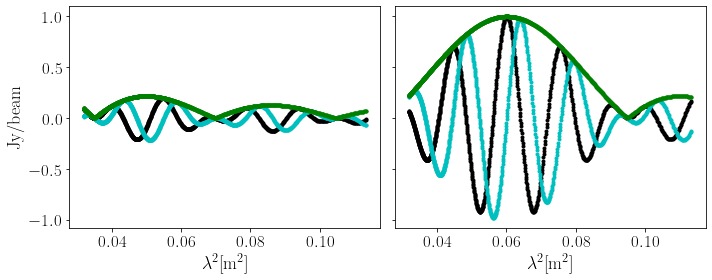

In [14]:
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(source_nolambda2_0.lambda2, source_nolambda2_0.data.real, 'k.', label=r"Stokes $Q$")
ax[0].plot(source_nolambda2_0.lambda2, source_nolambda2_0.data.imag, 'c.', label=r"Stokes $U$")
ax[0].plot(source_nolambda2_0.lambda2, np.abs(source_nolambda2_0.data), 'g.', label=r"$|P|$")
ax[0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0].set_ylabel(r'Jy/beam')

ax[1].plot(source_lambda2_0.lambda2, source_lambda2_0.data.real, 'k.', label=r"Stokes $Q$")
ax[1].plot(source_lambda2_0.lambda2, source_lambda2_0.data.imag, 'c.', label=r"Stokes $U$")
ax[1].plot(source_lambda2_0.lambda2, np.abs(source_lambda2_0.data), 'g.', label=r"$|P|$")
ax[1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
plt.tight_layout()

In [15]:
parameter_lambda2_0 = Parameter()
parameter_nolambda2_0 = Parameter()

In [16]:
parameter_lambda2_0.calculate_cellsize(dataset=source_lambda2_0, oversampling=8)

FWHM of the main peak of the RMTF: 42.422 rad/m^2
Maximum recovered width structure: 98.774 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 21189.543


In [17]:
parameter_nolambda2_0.calculate_cellsize(dataset=source_nolambda2_0, oversampling=8)

FWHM of the main peak of the RMTF: 42.422 rad/m^2
Maximum recovered width structure: 98.774 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 21189.543


In [18]:
dft_lambda2_0 = DFT1D(dataset=source_lambda2_0, parameter=parameter_lambda2_0)
dft_nolambda2_0 = DFT1D(dataset=source_nolambda2_0, parameter=parameter_nolambda2_0)

In [19]:
F_dirty_lambda2_0 = dft_lambda2_0.backward(source_lambda2_0.data)
F_dirty_nolambda2_0 = dft_nolambda2_0.backward(source_nolambda2_0.data)

rmtf_lambda2_0 = dft_lambda2_0.RMTF()
rmtf_nolambda2_0 = dft_nolambda2_0.RMTF()

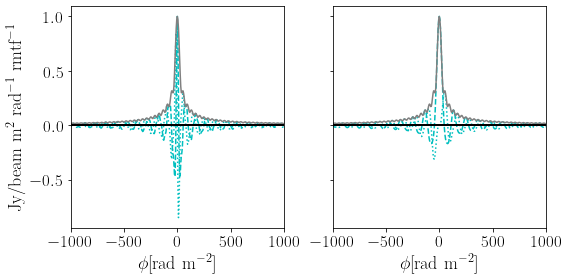

In [20]:
fig, ax = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(parameter_nolambda2_0.phi, rmtf_nolambda2_0.real, 'c--', label=r"Stokes $Q$")
ax[0].plot(parameter_nolambda2_0.phi, rmtf_nolambda2_0.imag, 'c:', label=r"Stokes $U$")
ax[0].plot(parameter_nolambda2_0.phi, np.abs(rmtf_nolambda2_0), '-', c='grey', label=r"|P|")
ax[0].plot(parameter_nolambda2_0.phi, np.zeros(len(parameter_nolambda2_0.phi)), ls='-', lw=2., c='black')
ax[0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[0].set_xlim([-1000, 1000])

ax[1].plot(parameter_lambda2_0.phi, rmtf_lambda2_0.real, 'c--', label=r"Stokes $Q$")
ax[1].plot(parameter_lambda2_0.phi, rmtf_lambda2_0.imag, 'c:', label=r"Stokes $U$")
ax[1].plot(parameter_lambda2_0.phi, np.abs(rmtf_lambda2_0), '-', c='grey', label=r"|P|")
ax[1].plot(parameter_lambda2_0.phi, np.zeros(len(parameter_lambda2_0.phi)), ls='-', lw=2., c='black')
ax[1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1].set_xlim([-1000, 1000])

plt.tight_layout()

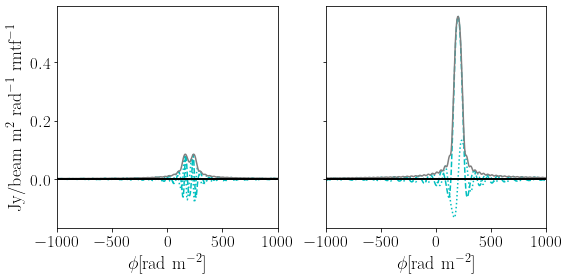

In [21]:
fig, ax = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(parameter_nolambda2_0.phi, F_dirty_nolambda2_0.real, 'c--', label=r"Stokes $Q$")
ax[0].plot(parameter_nolambda2_0.phi, F_dirty_nolambda2_0.imag, 'c:', label=r"Stokes $U$")
ax[0].plot(parameter_nolambda2_0.phi, np.abs(F_dirty_nolambda2_0), '-', c='grey', label=r"|P|")
ax[0].plot(parameter_nolambda2_0.phi, np.zeros(len(parameter_nolambda2_0.phi)), ls='-', lw=2., c='black')
ax[0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[0].set_xlim([-1000, 1000])

ax[1].plot(parameter_lambda2_0.phi, F_dirty_lambda2_0.real, 'c--', label=r"Stokes $Q$")
ax[1].plot(parameter_lambda2_0.phi, F_dirty_lambda2_0.imag, 'c:', label=r"Stokes $U$")
ax[1].plot(parameter_lambda2_0.phi, np.abs(F_dirty_lambda2_0), '-', c='grey', label=r"|P|")
ax[1].plot(parameter_lambda2_0.phi, np.zeros(len(parameter_lambda2_0.phi)), ls='-', lw=2., c='black')
ax[1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1].set_xlim([-1000, 1000])

plt.tight_layout()